# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from keras.layers import Dense, SimpleRNN, RepeatVector, Dropout
from keras.layers import TimeDistributed, LSTM, GRU, Activation, BatchNormalization
from keras.models import Sequential

from scipy.stats import spearmanr

# Load neural network model architectures and utils
import neural_models as nm
from neural_utils import *

sns.set_style("white")
%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Read Data

In [2]:
## Read data
si_data = pd.read_csv('Si_all_velocities.csv')
si_data['velocity'] = si_data['velocity_mag'].map(lambda x: round(x, 2))
si_group = si_data.groupby(['velocity'])

si_dfs = []
al_dfs = []

for name, df in si_group:
    df['eng_force t-1'] = df['force'].shift(1).fillna(0.0)
    #df['eng_force pct5'] = df['force'].rolling(5).mean().fillna(0.0)
    #df['eng_force pct10'] = df['force'].rolling(10).mean().fillna(0.0)
    si_dfs.append(df)

si_dfs = pd.concat(si_dfs)
si_group = si_dfs.groupby(['velocity'])

al_data = pd.read_csv('Al_all_velocities.csv')
al_data['velocity'] = al_data['velocity_mag'].map(lambda x: round(x, 2))
al_group = al_data.groupby(['velocity'])

for name, df in al_group:
    df['eng_force t-1'] = df['force'].shift(1).fillna(0.0)
    #df['eng_force pct5'] = df['force'].rolling(5).mean().fillna(0.0)
    #df['eng_force pct10'] = df['force'].rolling(10).mean().fillna(0.0)
    al_dfs.append(df)
    
al_dfs = pd.concat(al_dfs)
al_group = al_dfs.groupby(['velocity'])

print("Si Groups")
print([name for name,group in si_group])
print("Al Groups")
print([name for name,group in al_group])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Si Groups
[0.12, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0]
Al Groups
[0.5, 1.0, 2.0, 3.0, 4.0]


In [4]:
al_group.get_group(0.5).head()

,directory,density t=1.000000,density t=0.000000,density t=-1.000000,density t=-2.000000,density t=-3.000000,density t=-4.000000,density t=-5.000000,AGNI eta=8.00e-01,AGNI eta=1.23e+00,...,AGNI eta=1.04e+01,AGNI eta=1.60e+01,ion-ion repulsion,velocity_mag,velocity_mag_exp=-2,velocity_mag_exp=-1,velocity_mag_exp=1,force,velocity,eng_force t-1
17168,256_Al/Dv0.5,0.030249,0.029009,0.028565,0.029797,0.032757,0.044262,0.293545,-0.000006,-0.003956,...,-0.055307,-0.053572,0.727827,0.5,0.36788,0.606531,1.648721,0.215609,0.5,0.000000
17169,256_Al/Dv0.5,0.030266,0.029025,0.028558,0.029769,0.032698,0.043782,0.281911,-0.000006,-0.004035,...,-0.056195,-0.054462,0.738972,0.5,0.36788,0.606531,1.648721,0.215535,0.5,0.215609
17170,256_Al/Dv0.5,0.030283,0.029042,0.028552,0.029742,0.032640,0.043317,0.270568,-0.000007,-0.004114,...,-0.057077,-0.055347,0.750039,0.5,0.36788,0.606531,1.648721,0.215451,0.5,0.215535
17171,256_Al/Dv0.5,0.030300,0.029058,0.028545,0.029714,0.032582,0.042866,0.259513,-0.000007,-0.004194,...,-0.057954,-0.056227,0.761028,0.5,0.36788,0.606531,1.648721,0.215357,0.5,0.215451
17172,256_Al/Dv0.5,0.030317,0.029075,0.028539,0.029687,0.032525,0.042429,0.249893,-0.000007,-0.004275,...,-0.058824,-0.057101,0.771940,0.5,0.36788,0.606531,1.648721,0.215255,0.5,0.215357


In [5]:
# Specify which velocities are train and test for Si
si_vels_train = [0.12,0.25, 0.5, 1.0, 2.0, 5.0]
si_vels_test =  [0.75, 1.5]

# Specify which velocities are train and test for Al
al_vels_train = [1.0]
al_vels_test = [2.0]

si_dfs_train = []
si_dfs_test = []

al_dfs_train = []
al_dfs_test = []

for vel in si_vels_train:
    si_dfs_train.append(si_group.get_group(vel))
for vel in  si_vels_test:
    si_dfs_test.append(si_group.get_group(vel))

for vel in al_vels_train:
    al_dfs_train.append(al_group.get_group(vel))
for vel in al_vels_test:
    al_dfs_test.append(al_group.get_group(vel))

In [6]:
## Split data into X and y
(X_si, y_si) = get_data_columns(si_dfs_train[0])
(X_al, y_al) = get_data_columns(al_dfs_train[0])

# Base Dense Multilayer NN
Note: Worth running this more epochs on GPU

## Model Architectures

## Try training in velocity batches

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
16723/16723 [==============================] - 2s 105us/step - loss: 0.0218 - mean_absolute_error: 0.0218
Epoch 2/2
16723/16723 [==============================] - 1s 75us/step - loss: 0.0238 - mean_absolute_error: 0.0238
Stopping Power: 0.002821187721565366 
MAE: 0.018318083467463546
Epoch 1/2
8299/8299 [==============================] - 0s 60us/step - loss: 0.0217 - mean_absolute_error: 0.0217
Epoch 2/2
8299/8299 [==============================] - 1s 61us/step - loss: 0.0185 - mean_absolute_error: 0.0185
Stopping P

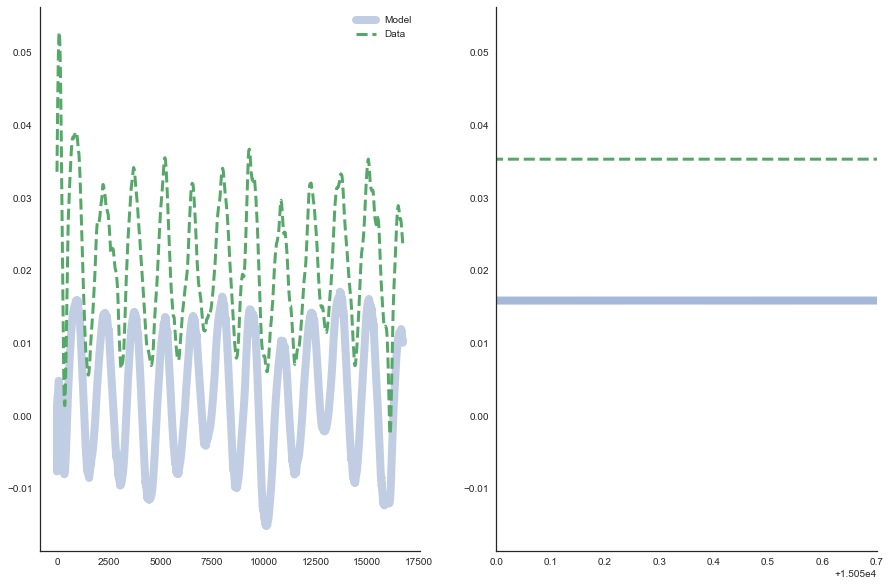

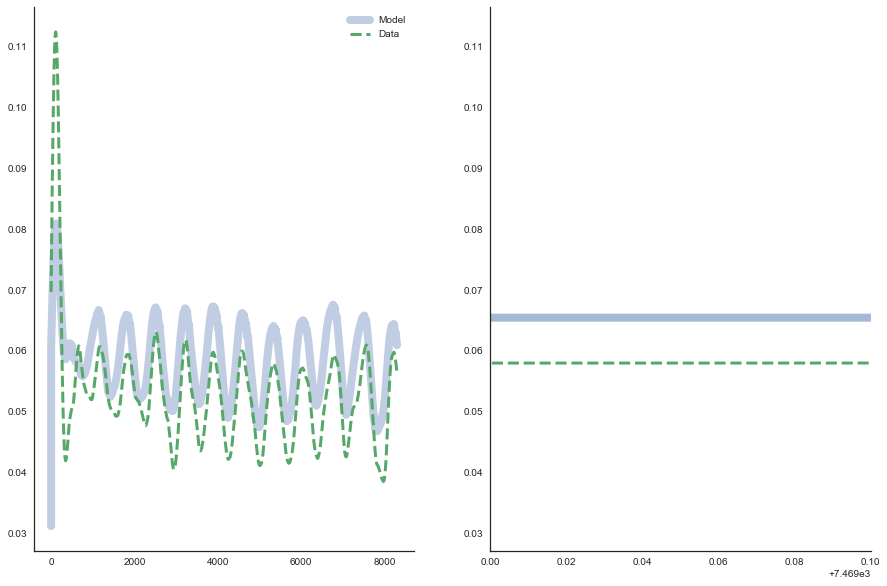

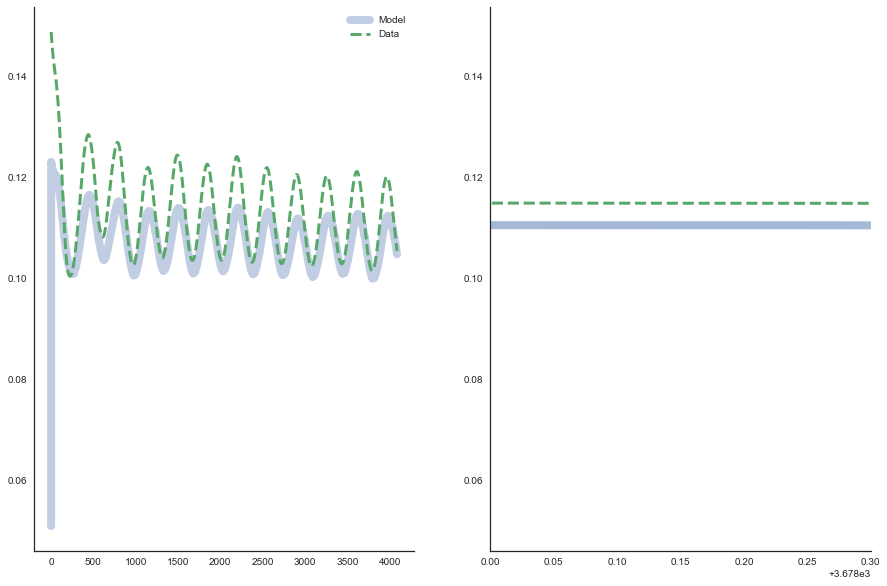

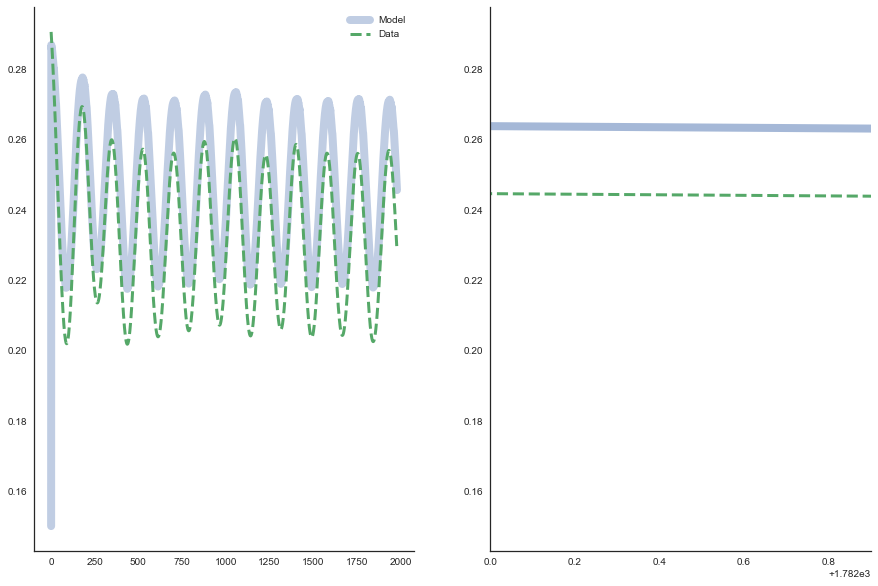

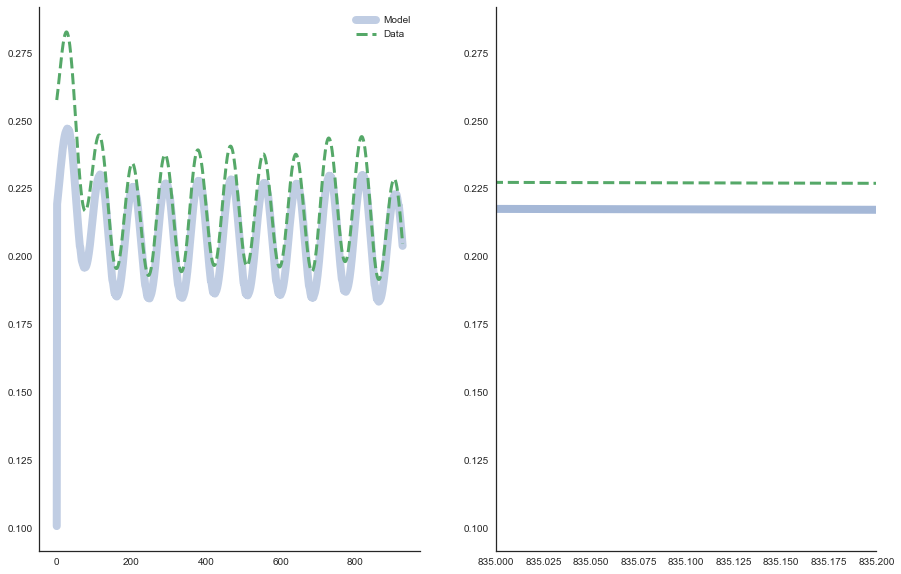

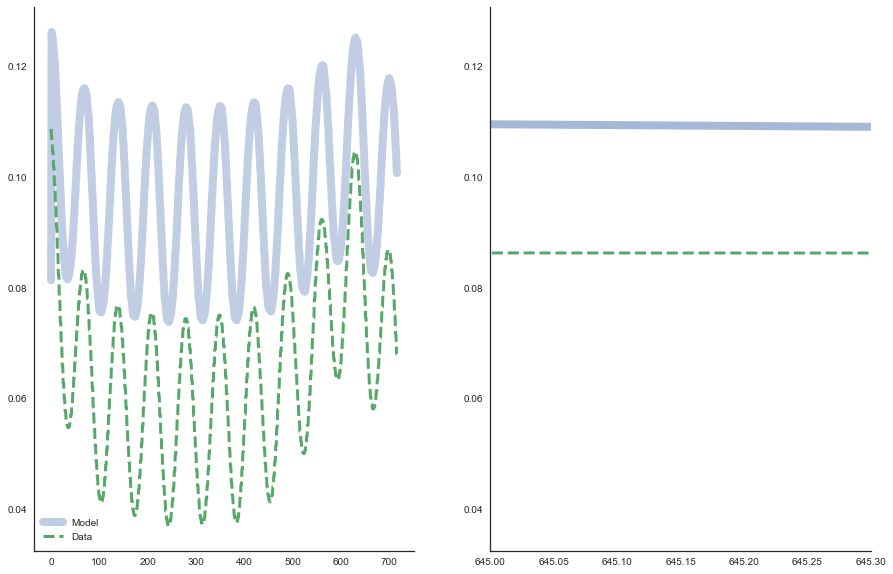

In [7]:
#Instantiate Model
model = nm.get_mlp_small(X_si)
epochs = 2

for df in si_dfs_train:
    (X_tr, y_tr) = get_data_columns(df)

    model, r = transfer_train(model, X_tr, y_tr,splits=[len(X_tr)], batch_size=25, epochs=epochs)

    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {}".format(sp,mae))
    summary_plots(preds, y_tr)

Epoch 1/20
16523/16523 [==============================] - 1s 57us/step - loss: 0.0330 - mean_absolute_error: 0.0330 - mean_squared_error: 0.0102
Epoch 2/20
16523/16523 [==============================] - 1s 39us/step - loss: 0.0090 - mean_absolute_error: 0.0090 - mean_squared_error: 1.2063e-04
Epoch 3/20
16523/16523 [==============================] - 1s 40us/step - loss: 0.0084 - mean_absolute_error: 0.0084 - mean_squared_error: 1.0517e-04
Epoch 4/20
16523/16523 [==============================] - 1s 45us/step - loss: 0.0075 - mean_absolute_error: 0.0075 - mean_squared_error: 8.3959e-05
Epoch 5/20
16523/16523 [==============================] - 1s 42us/step - loss: 0.0065 - mean_absolute_error: 0.0065 - mean_squared_error: 6.4130e-05
Epoch 6/20
16523/16523 [==============================] - 1s 42us/step - loss: 0.0058 - mean_absolute_error: 0.0058 - mean_squared_error: 5.2308e-05
Epoch 7/20
16523/16523 [==============================] - 1s 44us/step - loss: 0.0056 - mean_absolute_error: 0

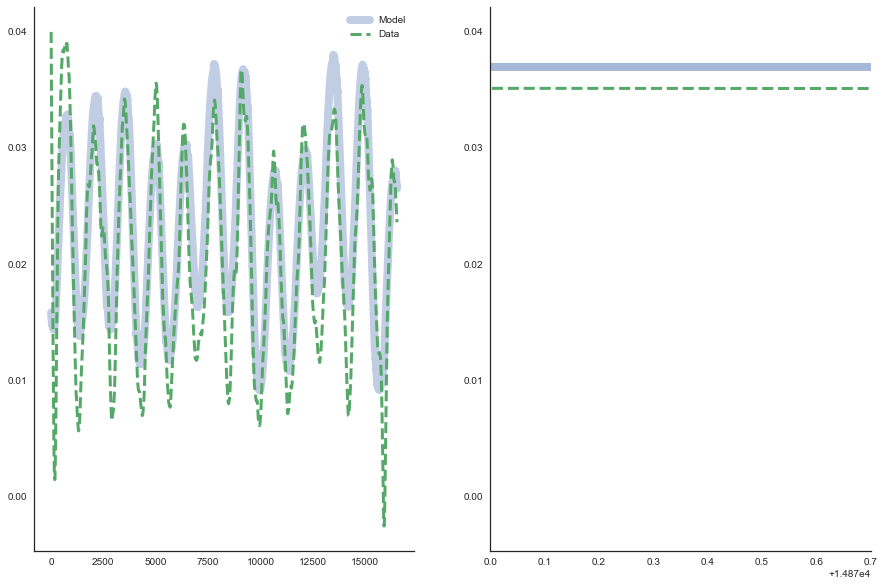

In [8]:
#Instantiate Model
cutoff = 200
X_tr, y_tr = (X_si[cutoff:], y_si[cutoff:])
model = nm.get_mlp_logan(X_tr, activation="tanh")
epochs = 20

model, r = transfer_train(model, X_tr, y_tr,splits=[len(X_tr)], 
                          batch_size=50, epochs=epochs, verbose=True)

preds, mae, sp = predict_summarize([model], X_tr, y_tr)
print("Stopping Power: {} \nMAE: {}\nSpearman {}".format(sp, mae, spearmanr(preds, y_tr)))
summary_plots(preds, y_tr)

In [9]:
fine_tune = False
fine_tune_ratio = 10
fine_tune_epochs = 25
test_set = dfs_si_test

for df in test_set:
    (X_tr, y_tr) = get_data_columns(df)

    if fine_tune:
        model, r = transfer_train(model, X_tr, y_tr,splits=[int(len(X_tr)/fine_tune_ratio)], 
                                  epochs=fine_tune_epochs)

    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {} \nPercent:{}".format(sp,mae, 100*float(mae/sp)))
    summary_plots(preds, y_tr)

NameError: name 'dfs_si_test' is not defined

## Try training in random groups

In [55]:
X_train = []
y_train = []
for df in si_dfs_train:
    (X_tr, y_tr) = get_data_columns(df)
    X_tr, y_tr = expand_class(X_tr, y_tr, length=length)
    X_train.append(X_tr)
    y_train.append(y_tr)

X_tr = np.vstack(X_train) 
y_tr = np.concatenate(y_train)

NameError: name 'length' is not defined

Epoch 1/10
16523/16523 [==============================] - 5s 328us/step - loss: 0.1090 - mean_absolute_error: 0.1090
Epoch 2/10
16523/16523 [==============================] - 5s 276us/step - loss: 0.0087 - mean_absolute_error: 0.0087
Epoch 3/10
16523/16523 [==============================] - 5s 274us/step - loss: 0.0079 - mean_absolute_error: 0.0079
Epoch 4/10
16523/16523 [==============================] - 5s 274us/step - loss: 0.0078 - mean_absolute_error: 0.0078
Epoch 5/10
16523/16523 [==============================] - 5s 275us/step - loss: 0.0078 - mean_absolute_error: 0.0078
Epoch 6/10
16523/16523 [==============================] - 5s 276us/step - loss: 0.0078 - mean_absolute_error: 0.0078
Epoch 7/10
16523/16523 [==============================] - 5s 277us/step - loss: 0.0078 - mean_absolute_error: 0.0078
Epoch 8/10
16523/16523 [==============================] - 5s 281us/step - loss: 0.0078 - mean_absolute_error: 0.0078
Epoch 9/10
16523/16523 [==============================] - 5s 274

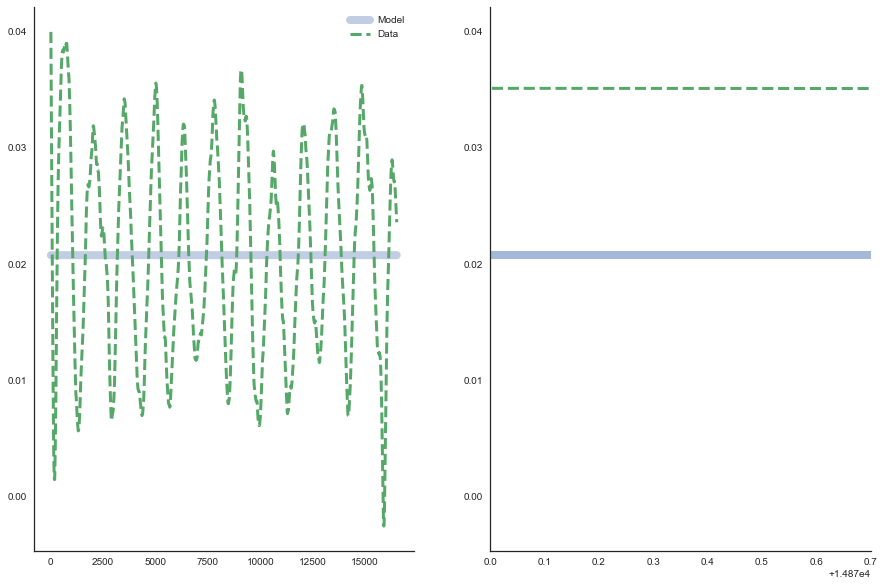

In [31]:
epochs = 10
length = 16000
batch_size = 50
splits = [len(X_tr)] # train on entire dataset
plots = True
model_results = []
# #Instantiate Model
## relu activation seems to work very poorly, don't need to train on that
## Initial obs  tanh > sigmoid > linear >> relu 
models = [("MLP Deep - sigmoid", nm.get_mlp_deep(X_si, activation="sigmoid"))]
trained_models = []

for model_name, model in models:
    model, r = transfer_train(model, 
                              X_tr, 
                              y_tr, 
                              splits=splits, 
                              batch_size=batch_size,
                              epochs=epochs)

    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    spearman = spearmanr(preds, y_tr)
    print("Stopping Power: {} \nMAE: {}\nSpearman {}".format(sp,mae, spearman))
    model_results.append({"mae":mae, "stopping":sp, 
                          "spearman":spearman, "model":model_name,
                         "batch_size":batch_size, "epochs":epochs, 
                         "splits":splits, "n_params":model.count_params()})
    trained_models.append({"model":model, "model_name":model_name})
    if plots:
        summary_plots(preds, y_tr)

In [58]:
df_results = pd.DataFrame(model_results)
df_results

,batch_size,epochs,mae,model,n_params,spearman,splits,stopping
0,50,10,0.008022,MLP Deep - sigmoid,719873,"(0.0856605746827, 1.29756477152e-28)",[16723],0.02094


In [86]:
df_results = pd.DataFrame(model_results)
df_results

,batch_size,epochs,mae,model,spearman,splits,stopping
0,50,10,0.013316,MLP Small - tanh,"(0.984912933867, 0.0)",[96723],0.128362
1,50,10,0.117176,MLP Small - relu,"(nan, nan)",[96723],0.000000
2,50,10,0.072199,MLP Small - linear,"(0.174770398878, 0.0)",[96723],0.114066


In [84]:
df_results = pd.DataFrame(model_results)
df_results

,mae,model,spearman,stopping
0,0.005605,MLP Logan - tanh,"(0.984654493785, 0.0)",0.116440
1,0.117176,MLP Logan - relu,"(nan, nan)",0.000000
2,0.069910,MLP Logan - linear,"(-0.0395244905493, 9.4129629658e-35)",0.101257


In [ ]:
fine_tune = False
fine_tune_ratio = 10
fine_tune_epochs = 25
test_set = si_dfs_test

for df in test_set:
    (X_tr, y_tr) = get_data_columns(df)

    if fine_tune:
        model, r = transfer_train(model, X_tr, y_tr,splits=[int(len(X_tr)/fine_tune_ratio)], 
                                  epochs=fine_tune_epochs)
        
    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {} \nPercent{}".format(sp,mae, 100*float(mae/sp)))
    summary_plots(preds, y_tr)

## Try Varyious MLP Model Architectures

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
4725/4725 [==============================] - 1s 218us/step - loss: 0.1122 - mean_absolute_error: 0.1122
Epoch 2/10
4725/4725 [==============================] - 0s 19us/step - loss: 0.0148 - mean_absolute_error: 0.0148
Epoch 3/10
4725/4725 [==============================] - 0s 19us/step - loss: 0.0275 - mean_absolute_error: 0.0275
Epoch 4/10
4725/4725 [==============================] - 0s 18us/step - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 5/10
4725/4725 [==============================] - 0s 20us/step - los

KeyboardInterrupt: 

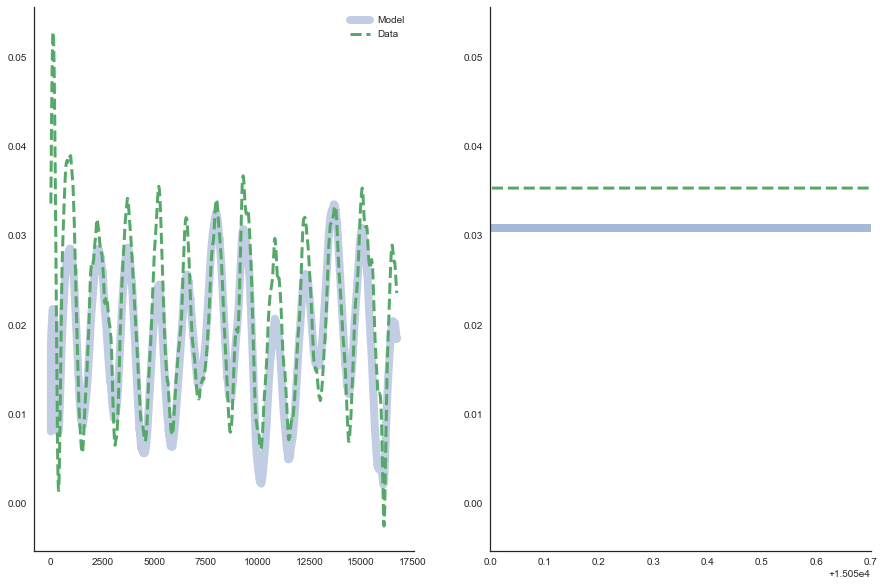

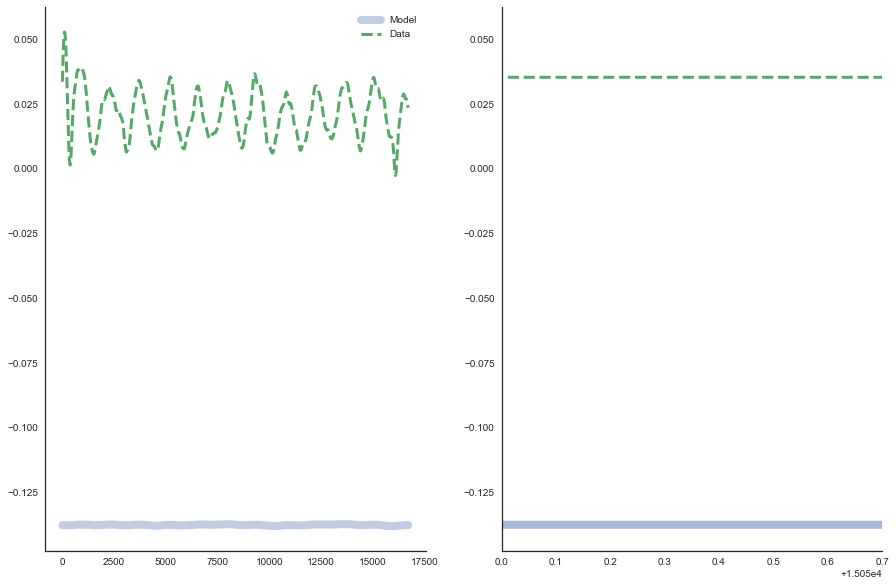

In [32]:
models = [(nm.get_mlp_small(X_si), "Small MLP"), 
          (nm.get_mlp_deep(X_si), "Deeper MLP"),
          (nm.get_mlp_wide(X_si), "Wider MLP"), 
          (nm.get_mlp_base(X_si), "Base MLP")]

X_tr, y_tr = (X_si, y_si)

splits = [4725]
epochs = 10
batch_size = 100
verbose = True
dfs = []
for model, model_name in models:
    model, r = train_over_times(model, X_tr, y_tr, splits, batch_size=batch_size, 
                                epochs=epochs, verbose=verbose)
    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {} \nPercent:{}".format(sp,mae, 100*float(mae/sp)))
    summary_plots(preds, y_tr)
    
    df_r = pd.DataFrame(r)
    df_r['model_name'] = model_name
    dfs.append(df_r)
mlp_results = pd.concat(dfs)
mlp_results

## Train-test split data

In [104]:
split = 4725
X, y = (X_si, y_si)

X_train, X_test, y_train, y_test = time_split(X_tr, y, split)

In [ ]:
n_models = 1
mlp_models = []
for i in range(0,n_models):
    model = get_mlp_model()
    hist = model.fit(X_train, y_train,epochs=50, batch_size=500, verbose=1)
    
    mlp_models.append(model)

In [ ]:
#models = [model for model, name in models]
preds, mae, sp = predict_summarize(models, X_si, y_si)
print("Stopping Power: {} \nMAE: {}".format(sp,mae))
summary_plots(preds, y_si)

In [ ]:
f,ax = plt.subplots()
ax = plt.plot(hist.history['loss'])
sns.despine()

# RNN Models

In [ ]:
data = pd.read_csv('training_set.csv')
charge_attrs = [x for x in data.columns if x.startswith('density')]
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]
ewald_attrs = ['ion-ion repulsion',]
y_col = 'force'
X_cols = charge_attrs + agni_attrs + ewald_attrs

array([[  0.00000000e+00,   0.00000000e+00,  -3.65230435e+00, ...,
          2.95416924e-03,  -5.96353621e-02,   1.24987646e-01],
       [  3.36306243e-02,   0.00000000e+00,  -3.65227241e+00, ...,
          2.97594650e-03,  -6.00581134e-02,   1.24987378e-01],
       [  3.39652154e-02,   0.00000000e+00,  -3.65224048e+00, ...,
          2.99769430e-03,  -6.04797446e-02,   1.24987109e-01],
       ..., 
       [  2.37391987e-02,   2.37809033e-02,  -3.65052034e+00, ...,
          9.06645024e-03,  -2.12399822e-02,   1.22204380e-01],
       [  2.36929397e-02,   2.37369972e-02,  -3.65060996e+00, ...,
          9.07962772e-03,  -2.14999749e-02,   1.22204199e-01],
       [  2.36446646e-02,   2.36909204e-02,  -3.65069957e+00, ...,
          9.09287726e-03,  -2.17616303e-02,   1.22204009e-01]])

In [37]:
n_post = 1
n_pre = 20
hidden_neurons = 256
feature_count = 18

model = nm.create_schleife_simple_rnn_model(hidden_neurons, 
                                         feature_count, 
                                         activation="tanh")

X_tr_k, y_tr_k = nm.keras_schleife_reshape(X_tr, y_tr, n_pre, n_post)
model.fit(X_tr_k, y_tr_k, epochs=50)

/Users/ben/Desktop/git/stopping-power-ml/neural_models.py:187: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences=False, activation=activation))
/Users/ben/Desktop/git/stopping-power-ml/neural_models.py:187: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=256, return_sequences=False, activation="tanh", input_shape=(None, 18))`
  return_sequences=False, activation=activation))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 256)               70400     
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 17        
Total params: 114,177
Trainable params: 114,177
Non-trainable params: 0
_________________________________________________________________
None

In [14]:
model.fit(X_tr_k, y_tr_k, epochs=50)

Epoch 1/50
16570/16570 [==============================] - 3s 184us/step - loss: 0.0015 - mean_absolute_error: 0.0015
Epoch 2/50
16570/16570 [==============================] - 3s 190us/step - loss: 0.0015 - mean_absolute_error: 0.0015
Epoch 3/50
16570/16570 [==============================] - 3s 192us/step - loss: 0.0015 - mean_absolute_error: 0.0015
Epoch 4/50
16570/16570 [==============================] - 3s 190us/step - loss: 0.0015 - mean_absolute_error: 0.0015
Epoch 5/50
16570/16570 [==============================] - 3s 195us/step - loss: 0.0016 - mean_absolute_error: 0.0016
Epoch 6/50
16570/16570 [==============================] - 3s 198us/step - loss: 0.0016 - mean_absolute_error: 0.0016
Epoch 7/50
16570/16570 [==============================] - 3s 196us/step - loss: 0.0018 - mean_absolute_error: 0.0018
Epoch 8/50
16570/16570 [==============================] - 3s 200us/step - loss: 0.0014 - mean_absolute_error: 0.0014
Epoch 9/50
16570/16570 [==============================] - 3s 206

nan

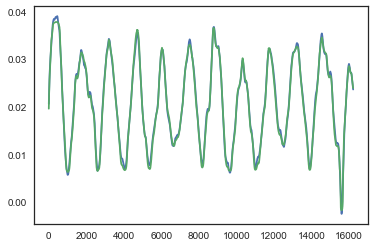

In [35]:
preds = model.predict(X_tr_k[500:])
plt.plot(y_tr[500:])
plt.plot(preds)

In [24]:
(np.mean(y_tr[500:])-np.mean(preds))/np.mean(y_tr[500:])

-0.029284113374538782

In [20]:
np.mean(preds)

0.021498844

In [12]:
n_post = 1
n_pre = 2
hidden_neurons = 512
feature_count = 20

model = nm.create_schleife_single_lstm_model(steps_before=n_pre, steps_after=n_post,hidden_neurons=hidden_neurons, feature_count=feature_count, activation="tanh")

X_tr_k, y_tr_k = nm.keras_schleife_reshape(X_tr, y_tr, n_pre, n_post)
model.fit(X_tr_k, y_tr_k, epochs=20)

/Users/ben/Desktop/git/stopping-power-ml/neural_models.py:147: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False, activation=activation))
/Users/ben/Desktop/git/stopping-power-ml/neural_models.py:147: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, activation="tanh", input_shape=(None, 20), units=512)`
  model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False, activation=activation))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1091584   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 512)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              513       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1)              0         
Total params: 1,092,097
Trainable params: 1,092,097
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Error when checking target: expected activation_1 to have 3 dimensions, but got array with shape (16570, 1)

In [93]:
si_dfs_train[0].head()

,directory,log density t=1.0,log density t=0.0,log density t=-1.0,log density t=-2.0,log density t=-3.0,log density t=-4.0,log density t=-5.0,AGNI eta=8.00e-01,AGNI eta=1.23e+00,...,AGNI eta=4.43e+00,AGNI eta=6.80e+00,AGNI eta=1.04e+01,AGNI eta=1.60e+01,ion-ion repulsion,velocity_mag,force,velocity,eng_force t-1,eng_force roll5
19046,datasets/Si\v_0.125,-3.652304,-3.654150,-3.655219,-3.655400,-3.654646,-3.652884,-3.650410,0.000003,0.000946,...,0.002847,0.002654,0.002675,0.002954,-0.059635,0.124988,0.033631,0.12,0.000000,0.000000
19047,datasets/Si\v_0.125,-3.652272,-3.654129,-3.655213,-3.655408,-3.654669,-3.652905,-3.650442,0.000003,0.000953,...,0.002866,0.002672,0.002694,0.002976,-0.060058,0.124987,0.033965,0.12,0.033631,0.000000
19048,datasets/Si\v_0.125,-3.652240,-3.654108,-3.655206,-3.655417,-3.654691,-3.652927,-3.650475,0.000003,0.000959,...,0.002886,0.002690,0.002713,0.002998,-0.060480,0.124987,0.034297,0.12,0.033965,0.000000
19049,datasets/Si\v_0.125,-3.652209,-3.654087,-3.655199,-3.655425,-3.654701,-3.652949,-3.650507,0.000003,0.000966,...,0.002905,0.002708,0.002731,0.003019,-0.060900,0.124987,0.034624,0.12,0.034297,0.000000
19050,datasets/Si\v_0.125,-3.652177,-3.654066,-3.655193,-3.655434,-3.654708,-3.652970,-3.650540,0.000003,0.000973,...,0.002924,0.002726,0.002750,0.003041,-0.061319,0.124987,0.034948,0.12,0.034624,0.034293


In [17]:
n_post = 1
n_pre = 2
hidden_neurons = 128
feature_count = 19

model = nm.create_schleife_simple_rnn_model(hidden_neurons, 
                                         feature_count, 
                                         activation="tanh")

trains = []
preds = []
actuals = []
for df in si_dfs_train:
    (X_tr, y_tr) = get_data_columns(df)
    X_tr_k, y_tr_k = nm.keras_schleife_reshape(X_tr,y_tr, n_pre, n_post)
    trains.append(X_tr_k)
    model.fit(X_tr_k, y_tr_k, epochs=10)
    actuals.append(y_tr)

/Users/ben/Desktop/git/stopping-power-ml/neural_models.py:187: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences=False, activation=activation))
/Users/ben/Desktop/git/stopping-power-ml/neural_models.py:187: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=128, return_sequences=False, activation="tanh", input_shape=(None, 19))`
  return_sequences=False, activation=activation))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 128)               18944     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_36 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 46,337
Trainable params: 46,337
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Error when checking input: expected simple_rnn_3_input to have shape (None, None, 19) but got array with shape (16720, 2, 20)

In [95]:
preds = []
for i in range(len(trains)):
    preds.append(model.predict(trains[i]))


6

In [96]:
def summary_stats(preds, y):
    mae = mean_absolute_error(preds,y)
    stopping_power = np.mean(preds)
    return(preds, mae, stopping_power)

ValueError: Found input variables with inconsistent numbers of samples: [16720, 16702]

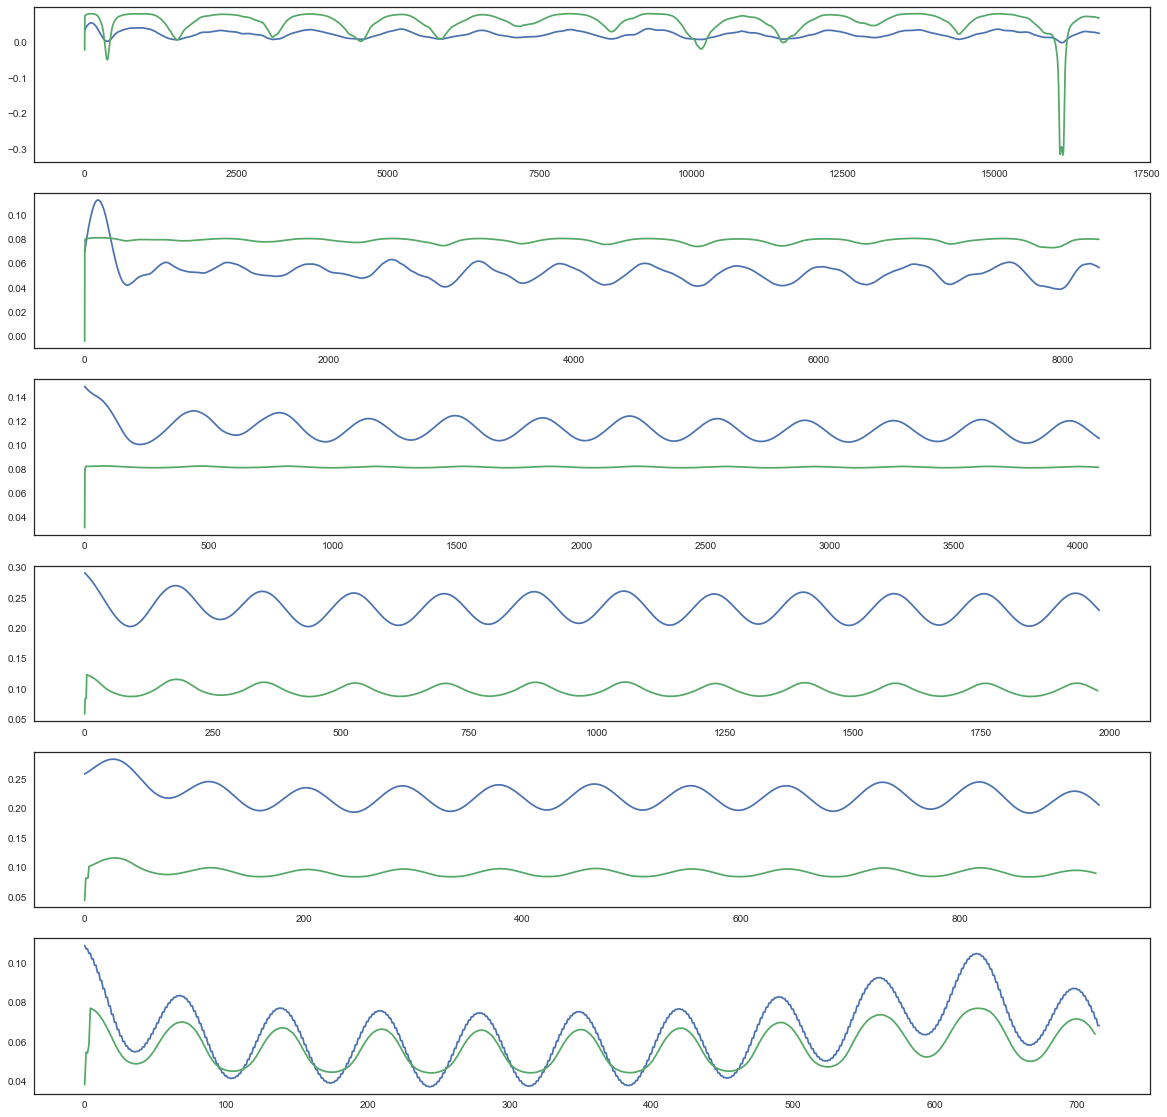

In [98]:
## 20
f, ax = plt.subplots(len(preds),1, figsize=(20, 20))
for i in range(len(preds)):
    ax[i].plot(actuals[i])
    ax[i].plot(preds[i])
    
for i in range(len(preds)):
    _, mae, sp = summary_stats(preds[i], actuals[i][21:])
    print(mae)
    print(sp)
    print()

ValueError: Found input variables with inconsistent numbers of samples: [16702, 16717]

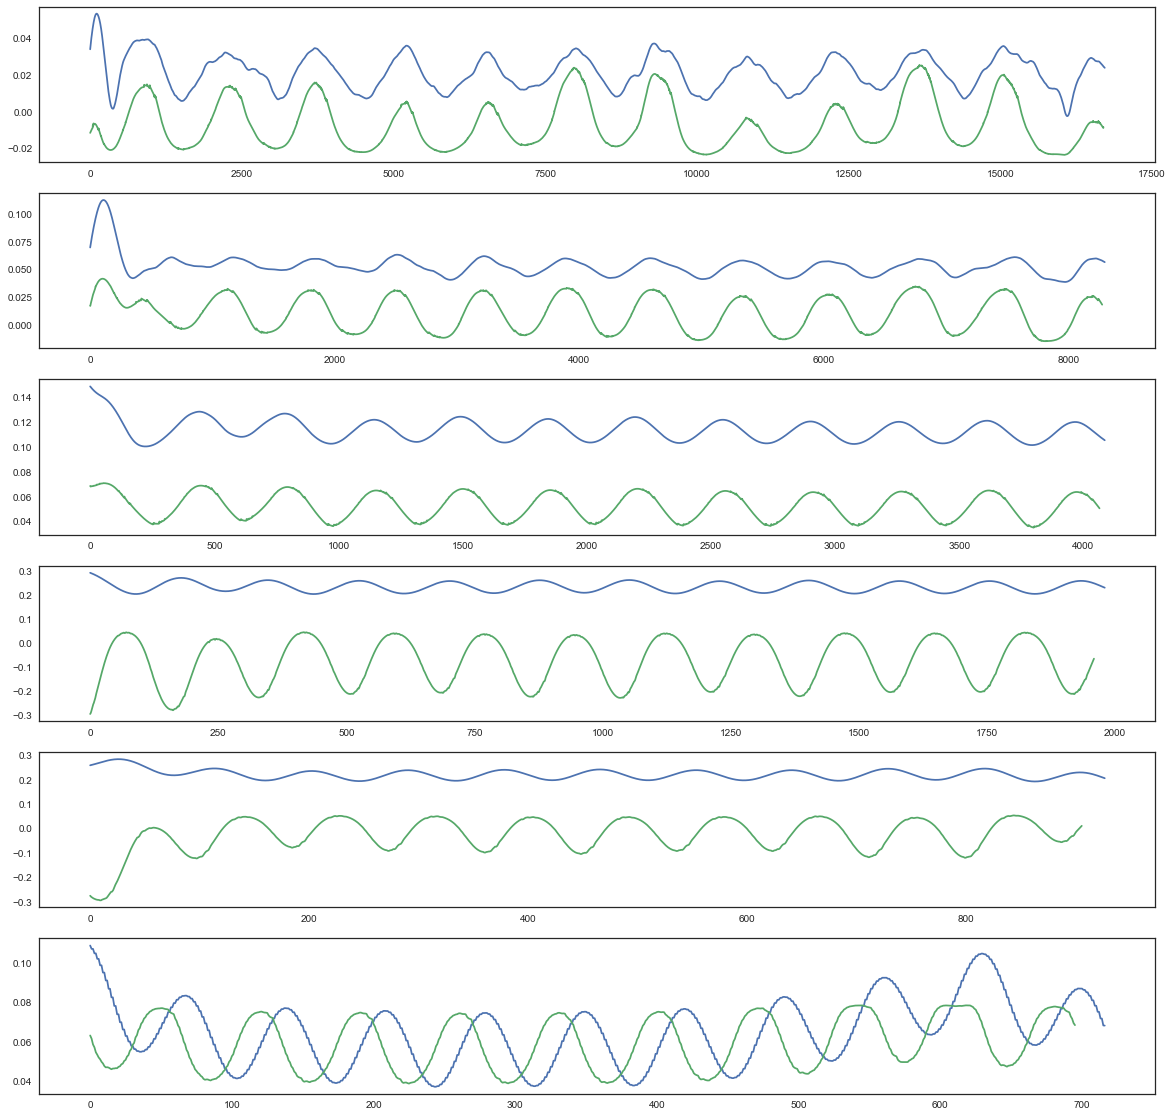

In [91]:
## 5
f, ax = plt.subplots(len(preds),1, figsize=(20, 20))
for i in range(len(preds)):
    ax[i].plot(actuals[i])
    ax[i].plot(preds[i])
    
for i in range(len(preds)):
    _, mae, sp = summary_stats(preds[i], actuals[i][6:])
    print(mae)
    print(sp)
    print()

In [ ]:
preds = model.predict(X_tr_k)
plt.plot(preds)
plt.plot(y_tr)

In [ ]:
preds.shape

In [ ]:
fine_tune = False
fine_tune_ratio = 10
fine_tune_epochs = 25
test_set = dfs_si_test

for df in test_set:
    (X_tr, y_tr) = get_data_columns(df)

    if fine_tune:
        model, r = transfer_train(model, X_tr, y_tr,splits=[int(len(X_tr)/fine_tune_ratio)], 
                                  epochs=fine_tune_epochs)
        
    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {} \nPercent{}".format(sp,mae, 100*float(mae/sp)))
    summary_plots(preds, y_tr)

In [107]:
def create_schleife_model(steps_before, steps_after, hidden_neurons, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    #model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))
    model.add(LSTM(output_dim=hidden_neurons, return_sequences=False))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
    print(model.summary())
    return model

def create_schleife_single_lstm_model(steps_before, steps_after, hidden_neurons, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
    print(model.summary())
    return model

def create_schleife_simple_rnn_model2(hidden_neurons, feature_count, activation="relu", steps_after=1):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(RepeatVector(steps_after))
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mae']) 
    print(model.summary())
    return model

def create_schleife_simple_rnn_model(hidden_neurons, feature_count, activation="relu"):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mae']) 
    print(model.summary())
    return model

def keras_schleife_reshape(data_x,data_y, n_pre, n_post):
    dX, dY = [], []
    for i in range(len(data_x)-n_pre-n_post):
        dX.append(data_x[i:i+n_pre])
        dY.append(data_y[i+n_pre:i+n_pre+n_post])

    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY

def train_schleife_model(model, dataX, dataY, epoch_count,validation_split=0.1, verbose=False):
    """ 
        trains only the sinus model
    """
    history = model.fit(dataX, dataY, batch_size=200, epochs=epoch_count, validation_split=validation_split, verbose=verbose)
    return history

In [ ]:
n_pre= 5
n_post = 1
n_dim = 16

X_ = data[X_cols].as_matrix()
y_ = data[y_col].as_matrix()

X,y = keras_schleife_reshape(X_,y_, n_pre, n_post)
print("Data shapes \nX:{} \ny{}".format(X.shape, y.shape))

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 3
n_epochs = 20
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_model(n_pre, n_post, 100, 16)
    h = train_schleife_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, SimpleRNN


split = 4725

X_train = X[0:split]
X_test = X[split:]

y_train = y[0:split]
y_test = y[split:]

activation = "linear"

print('creating model...')
models = []
n_models = 1
n_epochs = 20
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_simple_rnn_model2(10, 16, activation="linear")
    h = train_schleife_model(tmp_model, X_train, y_train, n_epochs, validation_split=0.0, verbose=True)
    models.append(tmp_model)

In [ ]:
preds = composite_predict(models, X)

# preds = []
# for i in range(0,n_models):
#     print(i)
#     preds.append(models[i].predict(X))
# composite_pred = np.mean(preds, axis=0) 

In [ ]:
mean_absolute_error(composite_pred, y)

In [ ]:
summary_plots(preds, y)

In [ ]:
preds = composite_predict(models,X)
mlp_mae = mean_absolute_error(preds,y)
stopping_power = np.mean(preds)
print("Stopping Power: {} \nMAE: {}".format(stopping_power,mlp_mae))

In [ ]:
fig, ax = plt.subplots()
ax.plot(h.history['loss'])
ax.set_xlim(0,300)
ax.set_ylim(0,0.2)

In [ ]:
# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 1
n_epochs = 10
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_single_lstm_model(n_pre, n_post, 500, 16)
    h = train_schleife_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

In [ ]:
def fit_on_whole_dataset(model, X, y):

    model.fit(X, y)

    fig, ax = plt.subplots()

#     for gid, group in data.groupby('directory'):
#         my_line, = ax.plot(group['displacement'], group['force'], linestyle='--', label=gid[3:].replace("_","="))

#         ax.plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)

#     ax.legend(ncol=2)

#     ax.set_xlabel('Timestep (a.u.)')
#     ax.set_ylabel('Force ($E_H / a_B$)')

In [ ]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(activation='tanh', hidden_layer_sizes=(128,64,32,16))


In [ ]:
#Instantiate Model
epochs = 5
length = 10000

X_train = []
y_train = []
for df in dfs_si_train:
    (X_tr, y_tr) = get_data_columns(df)
    X_tr, y_tr = expand_class(X_tr, y_tr, length=length)
    X_train.append(X_tr)
    y_train.append(y_tr)

X_train = np.vstack(X_train) 
y_train = np.concatenate(y_train)

model.fit(X_train, y_train)

In [ ]:
preds, mae, stopping_power = predict_summarize([model], X_train, y_train)
print("Stopping Power: {} \nMAE: {} \nPercent{}".format(sp,mae, 100*float(mae/sp)))


In [ ]:
summary_plots(preds, y_train)